In [41]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from yellowbrick.regressor import PredictionError, ResidualsPlot

In [2]:
df = pd.read_csv("data/house_price.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Handling Missing Value

In [3]:
total = df.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data.head(20)

,Total
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


Filling missing values For some columns there are many NaN entries. However, when re-reading the data description, there is some evidence that this is not missing data: For PoolQC, NaN is not missing data but means there is no pool, similarly for Fence, FireplaceQu, etc.

In [4]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    df[col].fillna('None',inplace=True)

In [5]:
total = df.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data.head(5)

,Total
LotFrontage,259
GarageYrBlt,81
MasVnrArea,8
Id,0
KitchenAbvGr,0


In [6]:
df['LotFrontage'].mean(),df['LotFrontage'].median()

(70.04995836802665, 69.0)

In [7]:
df['MasVnrArea'].mean(),df['MasVnrArea'].median()

(103.68526170798899, 0.0)

In [8]:
df['GarageYrBlt'].mean(),df['GarageYrBlt'].median()

(1978.5061638868744, 1980.0)

In [9]:
features_to_examine = ['LotFrontage','MasVnrArea','GarageYrBlt']
features_to_examine

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [10]:
for col in features_to_examine:
    df[col].fillna(df[col].median(),inplace=True)

In [11]:
df[features_to_examine].isna().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [12]:
df.isnull().sum().sort_values(ascending=False)

Id             0
CentralAir     0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
              ..
MasVnrArea     0
MasVnrType     0
Exterior2nd    0
Exterior1st    0
SalePrice      0
Length: 81, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Label Encoder

Converts categorical text data to numeric data for the model to understand

In [14]:
categorical_cols = df.dtypes[(df.dtypes == "object") | (df.dtypes == "string")].index

In [15]:
le = LabelEncoder()

for column in categorical_cols:
    df[column] = le.fit_transform(df[column])

In [16]:
X=df.drop(columns=['SalePrice','Id'],axis=1)
y=df['SalePrice']

X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,1,3,3,0,4,...,0,0,3,4,1,0,2,2008,8,4
1,20,3,80.0,9600,1,1,3,3,0,2,...,0,0,3,4,1,0,5,2007,8,4
2,60,3,68.0,11250,1,1,0,3,0,4,...,0,0,3,4,1,0,9,2008,8,4
3,70,3,60.0,9550,1,1,0,3,0,0,...,0,0,3,4,1,0,2,2006,8,0
4,60,3,84.0,14260,1,1,0,3,0,2,...,0,0,3,4,1,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,1,3,3,0,4,...,0,0,3,4,1,0,8,2007,8,4
1456,20,3,85.0,13175,1,1,3,3,0,4,...,0,0,3,2,1,0,2,2010,8,4
1457,70,3,66.0,9042,1,1,3,3,0,4,...,0,0,3,0,3,2500,5,2010,8,4
1458,20,3,68.0,9717,1,1,3,3,0,4,...,0,0,3,4,1,0,4,2010,8,4


In [17]:
print(X.isnull().sum())

X.fillna(X.median(), inplace=True)


MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64


## Regression

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the evaluation function
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse_val = np.sqrt(mse)
    return mae, mse, rmse_val, set_name

In [22]:
lasso_pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.001, random_state=42))
rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42, max_depth=5))
xgb_pipe = make_pipeline(StandardScaler(), XGBRegressor(random_state=42, max_depth=3))
lgbm_pipe = make_pipeline(StandardScaler(), LGBMRegressor(random_state=42, max_depth=3))

In [23]:
def train_and_evaluate(pipeline, X_train, y_train, X_test, y_test, model_name):
    pipeline.fit(X_train, y_train)
    train_scores = evaluate_model(pipeline, X_train, y_train, "Train")
    test_scores = evaluate_model(pipeline, X_test, y_test, "Test")
    return train_scores, test_scores

In [24]:
lasso_scores_train, lasso_scores_test = train_and_evaluate(lasso_pipe, X_train, y_train, X_test, y_test, "Lasso")
rf_scores_train, rf_scores_test = train_and_evaluate(rf_pipe, X_train, y_train, X_test, y_test, "Random Forest")
xgb_scores_train, xgb_scores_test = train_and_evaluate(xgb_pipe, X_train, y_train, X_test, y_test, "XGBoost")
lgbm_scores_train, lgbm_scores_test = train_and_evaluate(lgbm_pipe, X_train, y_train, X_test, y_test, "LightGBM")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3182
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 73
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [25]:
models_scores = [
    ['Lasso', *lasso_scores_train],
    ['Lasso', *lasso_scores_test],
    ['Random Forest', *rf_scores_train],
    ['Random Forest', *rf_scores_test],
    ['XGBoost', *xgb_scores_train],
    ['XGBoost', *xgb_scores_test],
    ['LightGBM', *lgbm_scores_train],
    ['LightGBM', *lgbm_scores_test]
]

In [27]:
for model, mae, mse, rmse, set_name in models_scores:
    print(f'{model} - {set_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}')

Lasso - Train - MAE: 18500.0422, MSE: 881879732.5644, RMSE: 29696.4599
Lasso - Test - MAE: 21785.7062, MSE: 1207136471.5681, RMSE: 34743.8696
Random Forest - Train - MAE: 16670.1076, MSE: 544061674.6013, RMSE: 23325.1297
Random Forest - Test - MAE: 20829.3946, MSE: 1030027580.5359, RMSE: 32094.0428
XGBoost - Train - MAE: 7078.2123, MSE: 88764164.1554, RMSE: 9421.4736
XGBoost - Test - MAE: 16800.4039, MSE: 705042137.9429, RMSE: 26552.6296
LightGBM - Train - MAE: 11585.1916, MSE: 321344667.8630, RMSE: 17926.0890
LightGBM - Test - MAE: 16958.0728, MSE: 816401006.1386, RMSE: 28572.7319


Based on the results above, XGBoost demonstrates better performance on the training data. The MAE and RMSE of XGBoost on the training data are significantly lower compared to other models. 

For the test data, the XGBoost model also performs well. Its MAE and RMSE are slightly higher compared to the training data but still better than those of the other models.

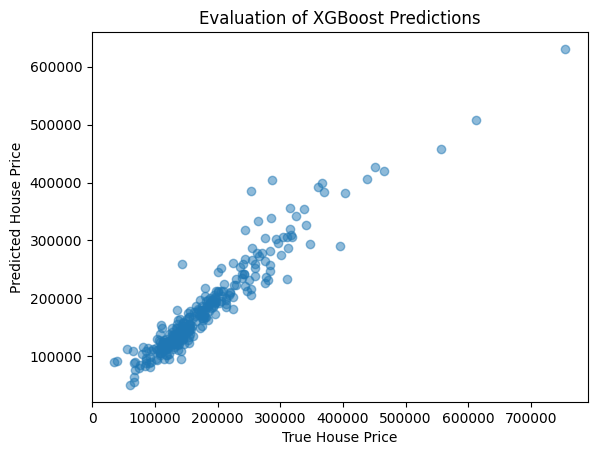

In [31]:
xgb = XGBRegressor(random_state=42, max_depth=3)
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Plot the true vs predicted values
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of XGBoost Predictions')
plt.show()

Text(0.5, 1.0, 'Evaluation of XGBoost Predictions')

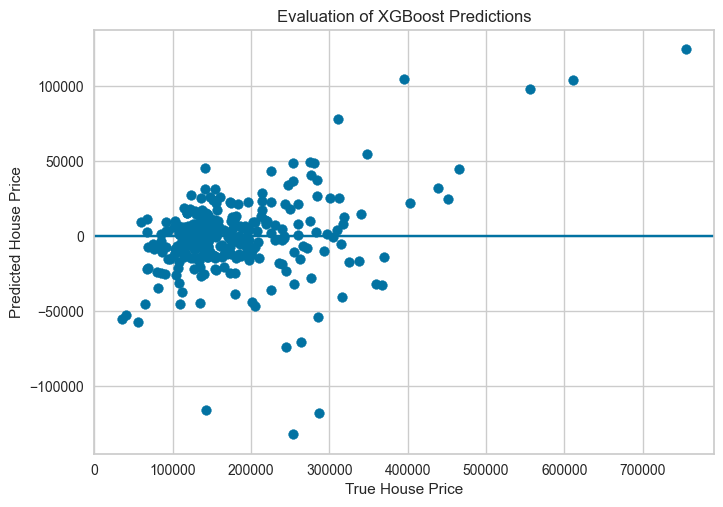

In [45]:
plt.scatter(y_test, y_test - xgb.predict(X_test))
plt.axhline(y=0)
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of XGBoost Predictions')

## Optuna Optimization

In [38]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),
        'random_state': 42
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate MAE, MSE, and RMSE
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return rmse

# Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='minimize')  # RMSE is minimized
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters on the entire training data
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)

[I 2024-09-08 19:57:54,621] A new study created in memory with name: no-name-c29e68e7-b343-4f09-aaf3-8283c214504b
[I 2024-09-08 19:57:55,321] Trial 0 finished with value: 25451.040696529788 and parameters: {'eta': 0.8, 'learning_rate': 0.01, 'n_estimators': 476, 'max_depth': 5}. Best is trial 0 with value: 25451.040696529788.
[I 2024-09-08 19:57:56,569] Trial 1 finished with value: 24711.607684632072 and parameters: {'eta': 0.3, 'learning_rate': 0.012, 'n_estimators': 944, 'max_depth': 5}. Best is trial 1 with value: 24711.607684632072.
[I 2024-09-08 19:57:57,289] Trial 2 finished with value: 26378.42556194054 and parameters: {'eta': 0.3, 'learning_rate': 0.01, 'n_estimators': 857, 'max_depth': 3}. Best is trial 1 with value: 24711.607684632072.
[I 2024-09-08 19:57:58,837] Trial 3 finished with value: 25823.373747046837 and parameters: {'eta': 1.0, 'learning_rate': 0.018, 'n_estimators': 531, 'max_depth': 7}. Best is trial 1 with value: 24711.607684632072.
[I 2024-09-08 19:57:59,751] T

Best Hyperparameters: {'eta': 0.3, 'learning_rate': 0.018, 'n_estimators': 775, 'max_depth': 5}
Test MAE: 15779.841970783391
Test MSE: 604883760.2234467
Test RMSE: 24594.384729515936


In [44]:
test_r2 = r2_score(y_test,y_pred_test)
print("Test R2 Score:", test_r2)

Test R2 Score: 0.921139760697965


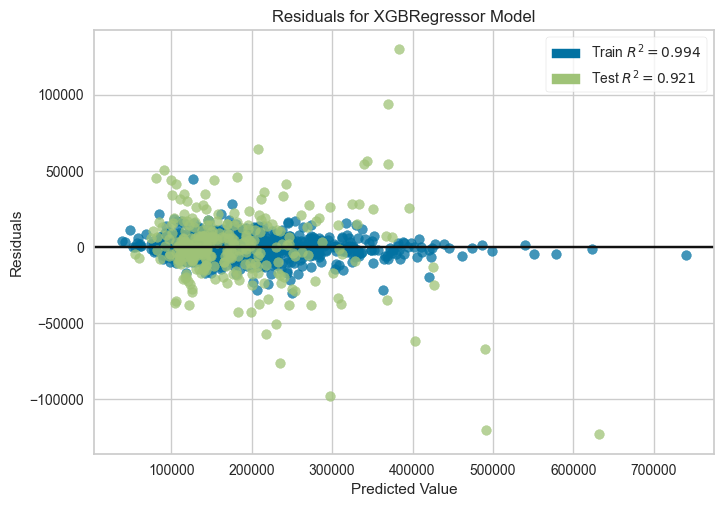

In [42]:
model = best_model
visualizer = ResidualsPlot(best_model, hist=False)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()

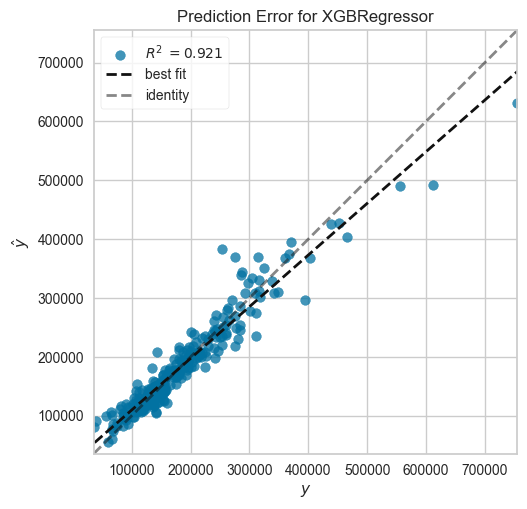

In [43]:
model = best_model
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

In [46]:
pred_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred_test,
    'Difference': y_test - y_pred_test
})

print(pred_df.head())

      Actual Value  Predicted Value    Difference
892         154500    142311.656250  12188.343750
1105        325000    350295.562500 -25295.562500
413         115000    110631.117188   4368.882812
522         159000    165328.453125  -6328.453125
1036        315500    330695.625000 -15195.625000
